In [20]:
"""
Custom struct for topogrpahy functions
"""
struct Topography
    f::Function
    params::Tuple
end

"""
Function describing a flat plane
"""
function flat(x)
    0
end

"""
Function describing a bump
# Arguments
- `x`: x coordinate
- `w`: width scaling
- `c`: x coordinate for the center of the bump
- `h`: optional arg for height scaling
"""
function bump(x, w, c, h=1)
    if x <= c-w || x >= c+w
        return 0
    else
        return h * exp(-(w^2/(w^2-(x-c)^2)))
    end
end

"""
Function describing a rectangular mound
# Arguments
- `x`: x coordinate
- `c`: x coordinate for left hand corner of mound
- `h`: height of mound
- `delta`: steepness of mound
- `w`: width of mound
"""
function mound(x, c, h, delta, w)
    h * (1/pi * (atan((x-c)/delta) - atan((x-c-w)/delta)))
end

"""
Custom struct for initial condition functions
"""
struct InitialCondition
    f::Function
    params::Tuple
end

"""
Function describing a reflected sigmoid
# Arguments
- `x`: x coordinate
- `b`: precursor film height
- `xf`: center point of transition
- `c`: steepness of transition
- `h`: optional argument control initial height
"""
function reflected_sigmoid(x, b, xf, c, h=1)
    b + (h-b)/(1 + exp(1/c * (x - xf)))
end

"""
Function describing a flat plane with respect to phi = 0
# Arguments
- `h`: film height relative to phi = 0
- `s`: topography
"""
function flat_profile(x, h, s, b=0.0)
    h - s + b
end

flat_profile

In [21]:
"""
Builds the system of ODEs (represented by du)
u = (h_-1, h_0, ..., h_nx, h_nx+1) where h_-1 and h_nx+1 are ghost points
"""
function system!(du, u, p, t)
    D, alpha, dx, topo, params = p

    function phi(i)
        u[i] + topo(dx*(i-2), params...)
    end
    function interp(i)
        1/2 * (u[i]^3 + u[i+1]^3)
    end
    function f1(i)
        1/(dx^2) * (interp(i-1)*(phi(i-1) - phi(i)) + interp(i)*(phi(i+1) - phi(i)))
    end
    function f2(i)
        (1/dx^4) * (interp(i-1)*(phi(i-2) - 3*phi(i-1) + 3*phi(i) - phi(i+1)) + interp(i)*(-phi(i-1) + 3*phi(i) - 3*phi(i+1) + phi(i+2)))
    end
    function f3(i)
        (1/(2*dx)) * (u[i+1]^3 - u[i-1]^3)
    end

    du[1] = 0
    du[2] = 0
    du[end-1] = 0
    du[end] = 0
    for i in 3:length(u)-2
        du[i] = D*cos(alpha)*f1(i) - f2(i) - sin(alpha)*f3(i)
    end
    return du
end

system!

In [40]:
# Discretization of x-domain
nx = 800
Lx = 40
dx = Lx/nx
x = 0.0:dx:Lx

# Topography definition
#topo = Topography(bump, (7.0,  20.0))
#topo = Topography(flat, ())
topo = Topography(mound, (19.5, 1, 0.001, 1))
s = topo.f.(x, topo.params...)

# Initial condition definition
#=
b = 0.0
ic_center = 5
ic_steep = 0.5
ic_height = 0.1
ic_obj = InitialCondition(reflected_sigmoid, (b, ic_center, ic_steep, ic_height))
=#

b = 0.0
ic_obj = InitialCondition(flat_profile, (1.0, s, b))

ic = ic_obj.f.(x, ic_obj.params...)
# Adding ghost points
pushfirst!(ic, ic[1])
push!(ic, ic[end])

# Parameters of the system of ODEs
D = 1
alpha = pi/4

xsym = Symbol.(x)
pushfirst!(xsym, Symbol("ghost1"))
push!(xsym, Symbol("ghost2"))

# Solve the system of ODEs
using DifferentialEquations

p = (D, alpha, dx, topo.f, topo.params)
tspan = (0.0, 40.0); save_every = 0.5
f = ODEFunction(system!, syms=xsym)
prob = ODEProblem(f, ic, tspan, p, saveat=save_every)
sol = solve(prob, alg=Rodas4())

retcode: Success
Interpolation: 1st order linear
t: 81-element Vector{Float64}:
  0.0
  0.5
  1.0
  1.5
  2.0
  2.5
  3.0
  3.5
  4.0
  4.5
  ⋮
 36.0
 36.5
 37.0
 37.5
 38.0
 38.5
 39.0
 39.5
 40.0
u: 81-element Vector{Vector{Float64}}:
 [0.9999992037276163, 0.9999992037276163, 0.9999991997287625, 0.9999991956997034, 0.9999991916401338, 0.999999187549745, 0.9999991834282241, 0.9999991792752543, 0.9999991750905147, 0.9999991708736804  …  0.9999991708736804, 0.9999991750905147, 0.9999991792752543, 0.9999991834282241, 0.999999187549745, 0.9999991916401338, 0.9999991956997034, 0.9999991997287625, 0.9999992037276163, 0.9999992037276163]
 [0.9999992037276163, 0.9999992037276163, 0.9999992036578823, 0.9999992035171075, 0.9999992033039322, 0.9999992030169554, 0.9999992026547547, 0.9999992022158737, 0.9999992016988422, 0.9999992011021733  …  0.999999177773619, 0.9999991830658271, 0.9999991878678187, 0.9999991921347531, 0.9999991958196277, 0.9999991988733642, 0.9999992012448877, 0.99999920288122

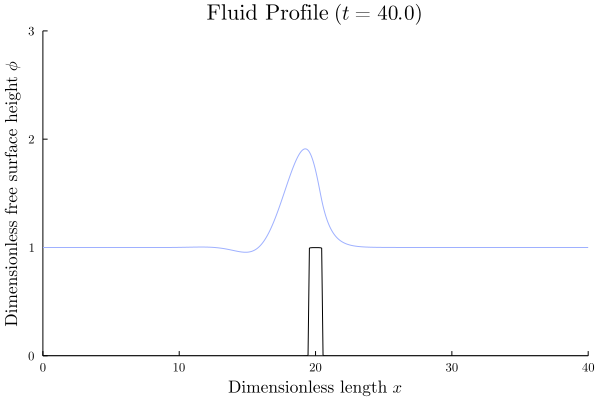

In [41]:
using Plots

function plot_timestep(x, sol, i)
    if i == -1
        timestep = sol.t[end]
        plt = plot(x, sol.u[end][2:end-1]+s, title=L"Fluid Profile $(t=%$timestep)$",
            xlabel=L"Dimensionless length $x$", ylabel=L"Dimensionless free surface height $\phi$")
    else
        timestep = sol.t[i]
        plt = plot(x, sol.u[i][2:end-1]+s, title=L"Fluid Profile $(t=%$timestep)$",
            xlabel=L"Dimensionless length $x$", ylabel=L"Dimensionless free surface height $\phi$")
    end
    plot!(plt, x, s, color="black", ylims=(0, 3), xlims=(0, Lx), legends=false)
end

plot_timestep(x, sol, -1)

In [24]:

using Plots, LaTeXStrings, ColorSchemes
Plots.PyPlotBackend()

plot_font = "Computer Modern"
default(fontfamily=plot_font, grid=false, color = ColorSchemes.berlin[1])

# Controls the time step between fluid profile plotting
time_skip = 2
dt = floor(Int64, time_skip/save_every)

plt = plot(x, s, dpi=200, xlabel=L"Dimensionless length $x$", ylabel=L"Dimensionless free surface height $\phi$", legend=false, color="black",
        title=L"Fluid profile at $\delta t = %$time_skip$ intervals", ylims=(0, Inf), xlims=(0, Lx))
for i = 1:floor(Int64, tspan[2]/time_skip)+1
    plot!(plt, x, sol.u[1 + dt*(i-1)][2:end-1] + s)
end
plot!(plt, x, s, color="black")

# Animates fluid profile based on time steps sepcified in ODE solver
anim = @animate for i = 1:size(sol.u)[1]
    timestep = sol.t[i]
    plot(x, sol.u[i][2:end-1]+s, legend=false, ylims=(0, 3), xlims=(0, Lx), title=L"Fluid Profile $(t=%$timestep)$", 
    xlabel=L"Dimensionless length $x$", ylabel=L"Dimensionless free surface height $\phi$")
    plot!(x, s, color="black")
end

using Dates, CSV, DataFrames

run_tag = string(Dates.format(now(), "YYYYmmdd-HHMMSS"))
path = "../runs/$run_tag"

mkpath(path)
gif(anim, path * "/flow.gif", fps = 30)
savefig(plt, path * "/plt.png")
df = DataFrame(sol)
#=
CSV format
First Col - Timestamp
Rest of Cols - Data including ghost points
=#
CSV.write(path * "/data.csv", df)

function save_params(path, filename="params")
    open(path*"/"*filename*".txt", "w") do f
        domain_info = "# Domain Parameters\nnx: $nx\nLx: $Lx\ndx: $dx\n"
        topo_info = "\n# Topography Parameters\n$topo\n"
        init_cond_info = "\n# Initial Condition Parameters\n$ic_obj\n"
        ode_sys_info = "\n# ODE System Parameters\nD: $D\nalpha: $alpha\n"
        time_info = "\n# Time Parameters\ntime_span: $tspan\ntimestep_save: $save_every"
        write(f, domain_info * topo_info * init_cond_info * ode_sys_info * time_info)
    end
end

save_params(path)

┌ Info: Saved animation to 
│   fn = /Users/bsamineni/Documents/research_projects/acoustics_thin_film/project/runs/20220228-152509/flow.gif
└ @ Plots /Users/bsamineni/.julia/packages/Plots/LI4FE/src/animation.jl:114


18245